# Gravity Model PPML Estimation

## Formalization of the gravity model equation
### with origin-destination (importer-exporter) fixed effects and lagged independent variables

\begin{equation}
\begin{split}
EXPORT_{ij,t} =\; &\exp\Bigl[\hat{\alpha}_{ij}
+ \sum_{k=1}^5 \hat{\beta}_{1k}\,GDP_{i,t-k}
+ \sum_{l=1}^5 \hat{\beta}_{2l}\,GDP_{j,t-l} \\
&\quad
+ \sum_{m=1}^5 \hat{\beta}_{3m}\,SANCT_{ij,t-m}\Bigr]
\times \epsilon_{ij,t}
\end{split}
\end{equation}

Where:
- $\hat\alpha_{ij}$ - time-invariant fixed effects
- $GDP_{i,t}$ - size of origin country $i$ at time $t$
- $GDP_{j,t}$ - size of destination country $j$ at time $t$
- $SANCT_{ij,t}$ - unilateral sanction relationship $i \rightarrow j$ at time $t$
- $\hat\beta_{1k}$, $\hat\beta_{2l}$, $\hat\beta_{3m}$ - estimated coefficients for the respective lagged variables
- $\epsilon_{ij,t}$ - error term


In [1]:
import gme
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from celer import Lasso, LassoCV
from pandas import DataFrame
from scipy import sparse
from sklearn.model_selection import GroupShuffleSplit

In [2]:
# Config for saving outputs
SAVE_ENABLED = True
SERIAL_NUMBER = "NOT_SET"
VERBOSE = 0

# Model parameters
N_LAGS = 5
N_DYADS = 1000
MAX_ITERATIONS = 5000

# Train parameters
TARGET = "EXPORT"
PATIENCE = 15
RANDOM_SEED = 16

SANCTION_COLS = ["arms", "military", "trade", "travel", "other"]

In [3]:
def mae(y_true: np.ndarray, y_pred: np.ndarray) -> float:
  y_true = np.asarray(y_true, dtype=float)
  y_pred = np.asarray(y_pred, dtype=float)
  return np.mean(np.abs(y_pred - y_true))


def rmae(y_true: np.ndarray, y_pred: np.ndarray) -> float:
  denom = np.mean(y_true)
  return np.nan if denom == 0 else mae(y_true, y_pred) / denom


def pseudo_r2(y_true: np.ndarray, y_pred: np.ndarray) -> float:
  y_true = np.asarray(y_true, dtype=float)
  y_pred = np.asarray(y_pred, dtype=float)

  sse = np.square(y_pred - y_true).sum()
  sst = np.square(y_true - y_true.mean()).sum()
  return np.nan if sst == 0 else 1.0 - sse / sst


def within_r2(y_true: np.ndarray,
              y_pred: np.ndarray,
              pair_ids: np.ndarray) -> float:
  y_true = np.asarray(y_true, dtype=float)
  y_pred = np.asarray(y_pred, dtype=float)
  pair_ids = np.asarray(pair_ids)

  df = pd.DataFrame({
    "y_true": y_true,
    "y_pred": y_pred,
    "pair": pair_ids
  })
  df["y_true_c"] = df["y_true"] - df.groupby("pair")["y_true"].transform("mean")

  sse_w = np.square(df["y_pred"] - df["y_true"]).sum()
  sst_w = np.square(df["y_true_c"]).sum()
  return np.nan if sst_w == 0 else 1.0 - sse_w / sst_w


def rmse(y_true, y_pred):
  y_true = np.asarray(y_true, dtype=float)
  y_pred = np.asarray(y_pred, dtype=float)
  mse = np.mean(np.square(y_pred - y_true))
  return np.sqrt(mse)

In [4]:
processed = pd.read_parquet(path="../data/model/processed.parquet", engine="fastparquet")
df: DataFrame = processed.copy(deep=True)

In [5]:
# Sort data by Report + Partner + Year
df["dyad_id"] = df["ISO3_reporter"] + "_" + df["ISO3_partner"]
df = df.sort_values(by=["dyad_id", "Year"]).reset_index(drop=True)

In [6]:
# dyad_subsample = pd.Series(df["dyad_id"].unique()).sample(n=N_DYADS, random_state=RANDOM_SEED, replace=False)
# df = df[df["dyad_id"].isin(dyad_subsample)]

In [7]:
df["GDP_reporter"] = np.log1p(df["GDP_reporter"]).astype(float)
df["GDP_partner"] = np.log1p(df["GDP_partner"]).astype(float)
df["EXPORT"] = np.log1p(df["EXPORT"])
df["sanction"] = (df[SANCTION_COLS]
                  .sum(axis=1)).astype(int)
df["distw"] = np.log1p(df["distw"]).astype(float)

In [8]:
# Coerce numerical values
num_cols = ["distw", "GDP_reporter", "GDP_partner", "sanction", "contig",
            "comlang_off", "colony", "smctry", "Year", ]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce").astype(float)
df = df.dropna(subset=num_cols)

In [9]:
lag_cols = ["GDP_reporter", "GDP_partner", "sanction"]
invariant_cols = ["contig", "comlang_off", "colony", "smctry", "distw"]

In [10]:
df["EXPORT_lag1"] = df.groupby("dyad_id")["EXPORT"].shift(1)

for col in lag_cols:
  for index in range(1, N_LAGS + 1):
    df[f"{col}_lag{index}"] = df.groupby("dyad_id")[col].shift(-index)

df = df.dropna()

df["Year"] = df["Year"].astype(int)
for col in ["dyad_id"]:
  df[col] = pd.Categorical(df[col], categories=sorted(df[col].unique()))

In [11]:
def add_fixed_effects(df: pd.DataFrame) -> pd.DataFrame:
  pl_df = pl.DataFrame({
    "fe_dyad_id": df["dyad_id"],
  })

  df_out = df.copy(deep=True)
  print("Df Shape: ", df_out.shape)
  fe_dummies = pl_df.to_dummies(columns=["fe_dyad_id"], drop_first=True).to_pandas()
  print("Dummies Shape: ", fe_dummies.shape)

  df_out = pd.concat([df.reset_index(drop=True), fe_dummies.reset_index(drop=True)], axis=1)
  print("Final Df Shape: ", df_out.shape)

  return df_out

In [12]:
df = add_fixed_effects(df)
df.head()

Df Shape:  (976515, 46)
Dummies Shape:  (976515, 33671)
Final Df Shape:  (976515, 33717)


,ISO3_reporter,UNDS_reporter,CNAME_reporter,ISO3_partner,UNDS_partner,CNAME_partner,Year,GDP_reporter,GDP_partner,contig,...,fe_dyad_id_ZWE_USA,fe_dyad_id_ZWE_UZB,fe_dyad_id_ZWE_VCT,fe_dyad_id_ZWE_VEN,fe_dyad_id_ZWE_VNM,fe_dyad_id_ZWE_VUT,fe_dyad_id_ZWE_WSM,fe_dyad_id_ZWE_YEM,fe_dyad_id_ZWE_ZAF,fe_dyad_id_ZWE_ZMB
0,AGO,024,Angola,ALB,008,Albania,1989,23.045828,21.535568,0.0,...,0,0,0,0,0,0,0,0,0,0
1,AGO,024,Angola,ALB,008,Albania,1990,23.141811,21.430589,0.0,...,0,0,0,0,0,0,0,0,0,0
2,AGO,024,Angola,ALB,008,Albania,1991,23.084477,20.818175,0.0,...,0,0,0,0,0,0,0,0,0,0
3,AGO,024,Angola,ALB,008,Albania,1992,22.840462,20.295823,0.0,...,0,0,0,0,0,0,0,0,0,0
4,AGO,024,Angola,ALB,008,Albania,1993,22.475716,20.893275,0.0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

train_df_idx, test_df_idx = next(gss.split(df, groups=df["dyad_id"]))
test_df = df.iloc[test_df_idx]
train_df = df.iloc[train_df_idx]
test_df.head(1)

,ISO3_reporter,UNDS_reporter,CNAME_reporter,ISO3_partner,UNDS_partner,CNAME_partner,Year,GDP_reporter,GDP_partner,contig,...,fe_dyad_id_ZWE_USA,fe_dyad_id_ZWE_UZB,fe_dyad_id_ZWE_VCT,fe_dyad_id_ZWE_VEN,fe_dyad_id_ZWE_VNM,fe_dyad_id_ZWE_VUT,fe_dyad_id_ZWE_WSM,fe_dyad_id_ZWE_YEM,fe_dyad_id_ZWE_ZAF,fe_dyad_id_ZWE_ZMB
0,AGO,024,Angola,ALB,008,Albania,1989,23.045828,21.535568,0.0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
rhs_cols = [f"{c}_lag{index}" for c in lag_cols for index in range(1, N_LAGS + 1)]
fe_columns = [col for col in train_df.columns if col.startswith("fe_dyad_id_")]
convert_to_float_columns = rhs_cols + invariant_cols
train_df.loc[:, convert_to_float_columns] = train_df.loc[:, convert_to_float_columns].astype(
  "float32",
  copy=False
)
rhs_cols = rhs_cols + invariant_cols + fe_columns

print("Fixed effects columns:", fe_columns[:10])
print("Lagged columns:", rhs_cols[:15])

Fixed effects columns: ['fe_dyad_id_AGO_AND', 'fe_dyad_id_AGO_ARE', 'fe_dyad_id_AGO_ARG', 'fe_dyad_id_AGO_ARM', 'fe_dyad_id_AGO_ATG', 'fe_dyad_id_AGO_AUS', 'fe_dyad_id_AGO_AUT', 'fe_dyad_id_AGO_AZE', 'fe_dyad_id_AGO_BDI', 'fe_dyad_id_AGO_BEL']
Lagged columns: ['GDP_reporter_lag1', 'GDP_reporter_lag2', 'GDP_reporter_lag3', 'GDP_reporter_lag4', 'GDP_reporter_lag5', 'GDP_partner_lag1', 'GDP_partner_lag2', 'GDP_partner_lag3', 'GDP_partner_lag4', 'GDP_partner_lag5', 'sanction_lag1', 'sanction_lag2', 'sanction_lag3', 'sanction_lag4', 'sanction_lag5']


In [15]:
# Prepare data
print("Selecting columns based on rhs_cols...")
col_idx = [train_df.columns.get_loc(c) for c in rhs_cols]
print("Finished extracting raw features.")

Selecting columns based on rhs_cols...
Finished extracting raw features.


In [ ]:
print("Extracting features from train_df...", flush=True)
X = train_df.iloc[:, col_idx].to_numpy(dtype=float, copy=False)
print("Finished extracting features.")
print("Creating sparse matrix from features...")
X = sparse.csr_matrix(X, dtype=float)
print("Finished creating sparse matrix from features.")

Extracting features from train_df...


In [17]:
y = train_df["EXPORT"].to_numpy(dtype=np.float32)
print("Finished extracting target variable.")

Finished extracting target variable.


In [18]:
# 1) Cross-validated Lasso to pick alpha
lasso_cv = LassoCV(cv=5, max_iter=MAX_ITERATIONS, tol=1e-4,
                   verbose=VERBOSE, n_jobs=-1)
print("Fitting celer.LassoCV (5-fold, all CPUs)…")
lasso_cv.fit(X, y)
cv_coef = lasso_cv.coef_

# Scale down the chosen alpha if desired
best_alpha = lasso_cv.alpha_ * 0.25
print(f"Selected alpha from CV: {best_alpha:.3e}")

Fitting celer.LassoCV (5-fold, all CPUs)…
Selected alpha from CV: 2.304e-03


In [19]:
# 2) Build threshold grid from non-zero CV coefficients
nz = np.abs(cv_coef[cv_coef != 0])
if nz.size == 0:
  print("Warning: no non-zero coefficients found! Using fallback.")
  nz = np.array([1e-5])
min_c, max_c = nz.min(), nz.max()
threshold_grid = np.logspace(np.log10(min_c / 10),
                             np.log10(max_c / 10), 10)
print("Threshold grid:", threshold_grid)

# 3) Fit final Lasso at best_alpha
print("Fitting final celer.Lasso…")
lasso_full = Lasso(alpha=best_alpha, max_iter=MAX_ITERATIONS,
                   tol=1e-4,
                   verbose=VERBOSE)
lasso_full.fit(X, y)
full_coef = lasso_full.coef_

Threshold grid: [0.00026314 0.00053615 0.0010924  0.00222576 0.004535   0.00924007
 0.01882666 0.03835936 0.07815729 0.15924566]
Fitting final celer.Lasso…


In [20]:
# 4) Loop over thresholds, refit on selected features, and compute RMSE
results_threshold = {
  "thresholds": [],
  "errors": [],
  "n_columns": [],
  "selected_columns": []
}

for thr in threshold_grid:
  print(f"\nThreshold {thr:.5f}")
  idx = np.where(np.abs(full_coef) >= thr)[0]
  cols = [rhs_cols[i] for i in idx]
  print(f"  -> {len(cols)} features selected")

  Xr = X[:, idx]
  lasso_sub = Lasso(alpha=best_alpha, max_iter=MAX_ITERATIONS,
                    tol=1e-4, verbose=VERBOSE)
  lasso_sub.fit(Xr, y)
  y_pred = lasso_sub.predict(Xr)
  err = rmse(y, y_pred)

  results_threshold["thresholds"].append(thr)
  results_threshold["errors"].append(err)
  results_threshold["n_columns"].append(len(cols))
  results_threshold["selected_columns"].append(cols)


Threshold 0.00026
  -> 349 features selected

Threshold 0.00054
  -> 349 features selected

Threshold 0.00109
  -> 349 features selected

Threshold 0.00223
  -> 349 features selected

Threshold 0.00453
  -> 346 features selected

Threshold 0.00924
  -> 346 features selected

Threshold 0.01883
  -> 343 features selected

Threshold 0.03836
  -> 340 features selected

Threshold 0.07816
  -> 328 features selected

Threshold 0.15925
  -> 313 features selected


In [21]:
best_idx = np.argmin(results_threshold["errors"])

best_rmse = results_threshold["errors"][best_idx]
best_columns = results_threshold["selected_columns"][best_idx]

print(f"Best RMSE: {best_rmse}")
print(f"Best columns ({len(best_columns)}):")
print(best_columns)

Best RMSE: 2.671310222028758
Best columns (343):
['GDP_reporter_lag1', 'GDP_reporter_lag4', 'GDP_reporter_lag5', 'GDP_partner_lag2', 'GDP_partner_lag3', 'GDP_partner_lag4', 'GDP_partner_lag5', 'sanction_lag3', 'sanction_lag5', 'contig', 'comlang_off', 'smctry', 'distw', 'fe_dyad_id_AGO_ISL', 'fe_dyad_id_AGO_SOM', 'fe_dyad_id_AND_KIR', 'fe_dyad_id_AND_PLW', 'fe_dyad_id_ARG_LSO', 'fe_dyad_id_ARM_CHE', 'fe_dyad_id_ATG_CPV', 'fe_dyad_id_AUS_BHR', 'fe_dyad_id_AUS_BRA', 'fe_dyad_id_AUS_JOR', 'fe_dyad_id_AZE_BWA', 'fe_dyad_id_BDI_TUV', 'fe_dyad_id_BEN_RWA', 'fe_dyad_id_BGD_HKG', 'fe_dyad_id_BGR_LTU', 'fe_dyad_id_BGR_TUV', 'fe_dyad_id_BHR_TJK', 'fe_dyad_id_BHS_IND', 'fe_dyad_id_BHS_MAR', 'fe_dyad_id_BIH_GTM', 'fe_dyad_id_BOL_AUS', 'fe_dyad_id_BOL_GNQ', 'fe_dyad_id_BRA_NGA', 'fe_dyad_id_BRN_LBY', 'fe_dyad_id_BWA_IRL', 'fe_dyad_id_CHE_CUB', 'fe_dyad_id_CHE_DEU', 'fe_dyad_id_CHE_JPN', 'fe_dyad_id_CHE_KOR', 'fe_dyad_id_CHL_DMA', 'fe_dyad_id_CHL_GTM', 'fe_dyad_id_CIV_SER', 'fe_dyad_id_CMR_BOL', 'fe

In [22]:
train_df.loc[:, 'ISO3_reporter'] = pd.Series(train_df['ISO3_reporter'].values, index=train_df.index).astype(str)
train_df.loc[:, 'ISO3_partner'] = pd.Series(train_df['ISO3_partner'].values, index=train_df.index).astype(str)
train_df.loc[:, 'Year'] = pd.to_numeric(train_df['Year'], errors='coerce')

In [23]:
for col in best_columns:
  train_df.loc[:, col] = pd.to_numeric(train_df[col], errors='coerce', downcast="float")

In [24]:
# Create estimation object
gme_data = gme.EstimationData(
  data_frame=train_df,
  imp_var_name="ISO3_reporter",
  exp_var_name="ISO3_partner",
  trade_var_name=TARGET,
  year_var_name="Year"
)
gme_data

number of countries: 184 
number of exporters: 179 
number of importers: 182 
number of years: 29 
number of sectors: not_applicable 
dimensions: (23200, 1045)

In [25]:
# Create GME model
gme_model = gme.EstimationModel(
  estimation_data=gme_data,
  lhs_var="EXPORT",
  rhs_var=best_columns,
  drop_intratrade=True
)

In [26]:
# Conduct PPML estimation of coefficients
estimates = gme_model.estimate()

Estimation began at 09:47 AM  on Jun 20, 2025
Omitted Regressors: ['fe_dyad_id_AND_PLW', 'fe_dyad_id_AZE_BWA', 'fe_dyad_id_BDI_TUV', 'fe_dyad_id_CIV_SER', 'fe_dyad_id_COM_PLW', 'fe_dyad_id_CPV_FJI', 'fe_dyad_id_CUB_BRN', 'fe_dyad_id_DJI_RUS', 'fe_dyad_id_DMA_DJI', 'fe_dyad_id_DOM_RWA', 'fe_dyad_id_EGY_TON', 'fe_dyad_id_FSM_LBN', 'fe_dyad_id_FSM_PRY', 'fe_dyad_id_GIN_SER', 'fe_dyad_id_GNQ_AGO', 'fe_dyad_id_HTI_BRA', 'fe_dyad_id_HTI_CHE', 'fe_dyad_id_HTI_DOM', 'fe_dyad_id_HTI_KWT', 'fe_dyad_id_IRQ_BHR', 'fe_dyad_id_IRQ_NIC', 'fe_dyad_id_IRQ_ZAF', 'fe_dyad_id_KGZ_TUV', 'fe_dyad_id_KIR_DJI', 'fe_dyad_id_KIR_DMA', 'fe_dyad_id_KIR_JAM', 'fe_dyad_id_KIR_MDV', 'fe_dyad_id_KIR_PRT', 'fe_dyad_id_KWT_HTI', 'fe_dyad_id_LBR_MDV', 'fe_dyad_id_LBY_SUR', 'fe_dyad_id_LCA_MDV', 'fe_dyad_id_MHL_BOL', 'fe_dyad_id_MHL_CUB', 'fe_dyad_id_MHL_GUY', 'fe_dyad_id_MHL_SWZ', 'fe_dyad_id_MHL_TUV', 'fe_dyad_id_MHL_VUT', 'fe_dyad_id_MKD_BEL', 'fe_dyad_id_MKD_BLR', 'fe_dyad_id_MKD_GHA', 'fe_dyad_id_MKD_RUS', 'fe_dyad_

In [27]:
gme_model.ppml_diagnostics

Overfit Warning                                                                  No
Number of Regressors Dropped                                                    105
Regressors with Zero Trade        [fe_dyad_id_AND_PLW, fe_dyad_id_AZE_BWA, fe_dy...
Regressors from User                                                             []
Regressors Perfectly Collinear                                                   []
Completion Time                                                        0.07 minutes
dtype: object

In [28]:
# estimates.keys()
results = estimates['all']
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 EXPORT   No. Observations:                20155
Model:                            GLM   Df Residuals:                    19917
Model Family:                 Poisson   Df Model:                          237
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -49310.
Date:                Fri, 20 Jun 2025   Deviance:                       62336.
Time:                        09:47:15   Pearson chi2:                 5.68e+04
No. Iterations:                    11   Pseudo R-squ. (CS):             0.9766
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
GDP_reporter_lag1      0.0124      0.025      0.488      0.625      -0.037       0.062
GDP_reporter_lag4      0.1647      0.060      2.726      0.006       0.046       0.283
GDP_reporter_lag5      0.0661      0.053      1.241      0.215      -0.038       0.170
GDP_partner_lag2      -0.0117      0.048     -0.243      0.808      -0.106       0.082
GDP_partner_lag3       0.0519      0.074      0.703      0.482      -0.093       0.197
GDP_partner_lag4       0.0413      0.075      0.548      0.583      -0.106       0.189
GDP_partner_lag5      -0.0249      0.047     -0.530      0.596      -0.117       0.067
sanction_lag3         -0.0422      0.014     -3.049      0.002      -0.069      -0.015
sanction_lag5         -0.0112      0.014     -0.809      0.419      -0.038       0.016
contig                -0.8987      0.051    -17.723      0.000      -0.998      -0.799
comlang_off            0.2218      0.022      9.956      0.000       0.178       0.265
smctry                -0.2345      0.072     -3.256      0.001      -0.376      -0.093
distw                 -0.7159      0.010    -74.845      0.000      -0.735      -0.697
fe_dyad_id_AGO_ISL    -2.4067      0.502     -4.789      0.000      -3.392      -1.422
fe_dyad_id_AGO_SOM    -3.0111      0.980     -3.072      0.002      -4.932      -1.090
fe_dyad_id_AND_KIR    -2.5366      0.981     -2.586      0.010      -4.459      -0.614
fe_dyad_id_ARG_LSO    -1.5780      0.504     -3.131      0.002      -2.566      -0.590
fe_dyad_id_ARM_CHE     0.7081      0.095      7.484      0.000       0.523       0.894
fe_dyad_id_ATG_CPV    -1.6080      0.697     -2.307      0.021      -2.974      -0.242
fe_dyad_id_AUS_BHR     1.0994      0.048     22.749      0.000       1.005       1.194
fe_dyad_id_AUS_BRA     1.1562      0.026     45.035      0.000       1.106       1.207
fe_dyad_id_AUS_JOR     1.2045      0.025     47.433      0.000       1.155       1.254
fe_dyad_id_BEN_RWA    -1.9427      0.411     -4.727      0.000      -2.748      -1.137
fe_dyad_id_BGD_HKG     0.1676      0.104      1.605      0.108      -0.037       0.372
fe_dyad_id_BGR_LTU    -0.0424      0.081     -0.522      0.601      -0.201       0.117
fe_dyad_id_BGR_TUV     0.1744      0.313      0.556      0.578      -0.440       0.789
fe_dyad_id_BHR_TJK    -2.0056      0.415     -4.837      0.000      -2.818      -1.193
fe_dyad_id_BHS_IND     0.1705      0.177      0.965      0.334      -0.176       0.517
fe_dyad_id_BHS_MAR    -2.1190      0.712     -2.976      0.003      -3.514      -0.724
fe_dyad_id_BIH_GTM    -1.7316      0.676     -2.561      0.010      -3.057      -0.407
fe_dyad_id_BOL_AUS     1.5817      0.057     27.584      0.000       1.469       1.694
fe_dyad_id_BOL_GNQ    -0.6899      0.402     -1.717      0.086      -1.477       0.097
fe_dyad_id_BRA_NGA     0.6195      0.0

In [29]:
betas = results.params
betas

GDP_reporter_lag1     0.012367
GDP_reporter_lag4     0.164667
GDP_reporter_lag5     0.066062
GDP_partner_lag2     -0.011659
GDP_partner_lag3      0.051931
                        ...   
fe_dyad_id_VNM_MWI   -0.774458
fe_dyad_id_WSM_CAN   -1.085381
fe_dyad_id_WSM_MNG   -5.455122
fe_dyad_id_YEM_LVA   -2.421049
fe_dyad_id_ZMB_CMR   -1.124721
Length: 238, dtype: float64

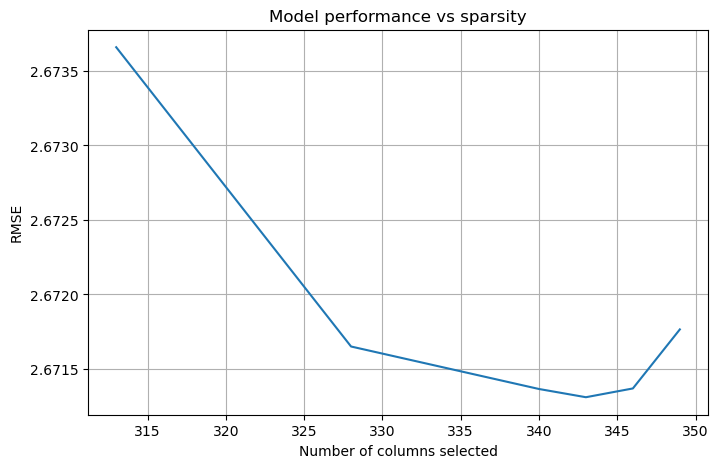

In [30]:
plt.figure(figsize=(8, 5))
plt.plot(results_threshold["n_columns"], results_threshold["errors"])
plt.xlabel("Number of columns selected")
plt.ylabel("RMSE")
plt.title("Model performance vs sparsity")
plt.grid()
plt.show()

In [31]:
betas = gme_model.results_dict["all"].params

for col in best_columns:
  test_df.loc[:, col] = pd.to_numeric(test_df[col], errors="coerce")
test_df = test_df.dropna(subset=best_columns)
model_columns = betas.index.tolist()

In [32]:
missing_cols = [col for col in model_columns if col not in test_df.columns]
if missing_cols:
  print(f"Warning: The following columns are missing in test_df: {missing_cols}")
  for col in missing_cols:
    test_df[col] = 0.0

In [33]:
X_test = test_df[model_columns].values
beta_values = betas[model_columns].values
linear_combination = X_test @ beta_values
test_df["EXPORT_hat"] = np.exp(linear_combination)

In [34]:
y_true = test_df["EXPORT"].values
y_pred = test_df["EXPORT_hat"].values

print(f"RMSE: {rmse(y_true, y_pred):.4f}")
print(f"MAE: {mae(y_true, y_pred):.4f}")
print(f"RMAE: {rmae(y_true, y_pred):.4f}")
print(f"Pseudo R²: {pseudo_r2(y_true, y_pred):.4f}")
print(f"Within R²: {within_r2(y_true, y_pred, test_df['dyad_id'].values):.4f}")

RMSE: 4.0070
MAE: 3.1144
RMAE: 0.7986
Pseudo R²: 0.3251
Within R²: -1.4594
